['fs', 'workloads', 'total_time(ns)', 'meta(ns)', 'data(ns)']
        fs     workloads  total_time(ns)      meta(ns)      data(ns)
0     nova         write     25992564230  1.670023e+10  9.292334e+09
1     nova     randwrite     27464001866  1.821237e+10  9.251629e+09
2     nova  fileserver.f      4833768429  2.511425e+09  2.322343e+09
3     nova     varmail.f      2138501636  7.709382e+08  1.367563e+09
4     nova   webserver.f      1167847599  3.277435e+08  8.401041e+08
5     nova    webproxy.f      1065720337  4.066576e+08  6.590627e+08
6   nvodin         write     29978695791  2.068636e+10  9.292334e+09
7   nvodin     randwrite     32206704270  2.295508e+10  9.251629e+09
8   nvodin  fileserver.f      5408357077  3.086014e+09  2.322343e+09
9   nvodin     varmail.f      2294402764  9.268393e+08  1.367563e+09
10  nvodin   webserver.f       934967900  9.486384e+07  8.401041e+08
11  nvodin    webproxy.f      1102171750  4.431090e+08  6.590627e+08
12  cknova         write     28624468586 

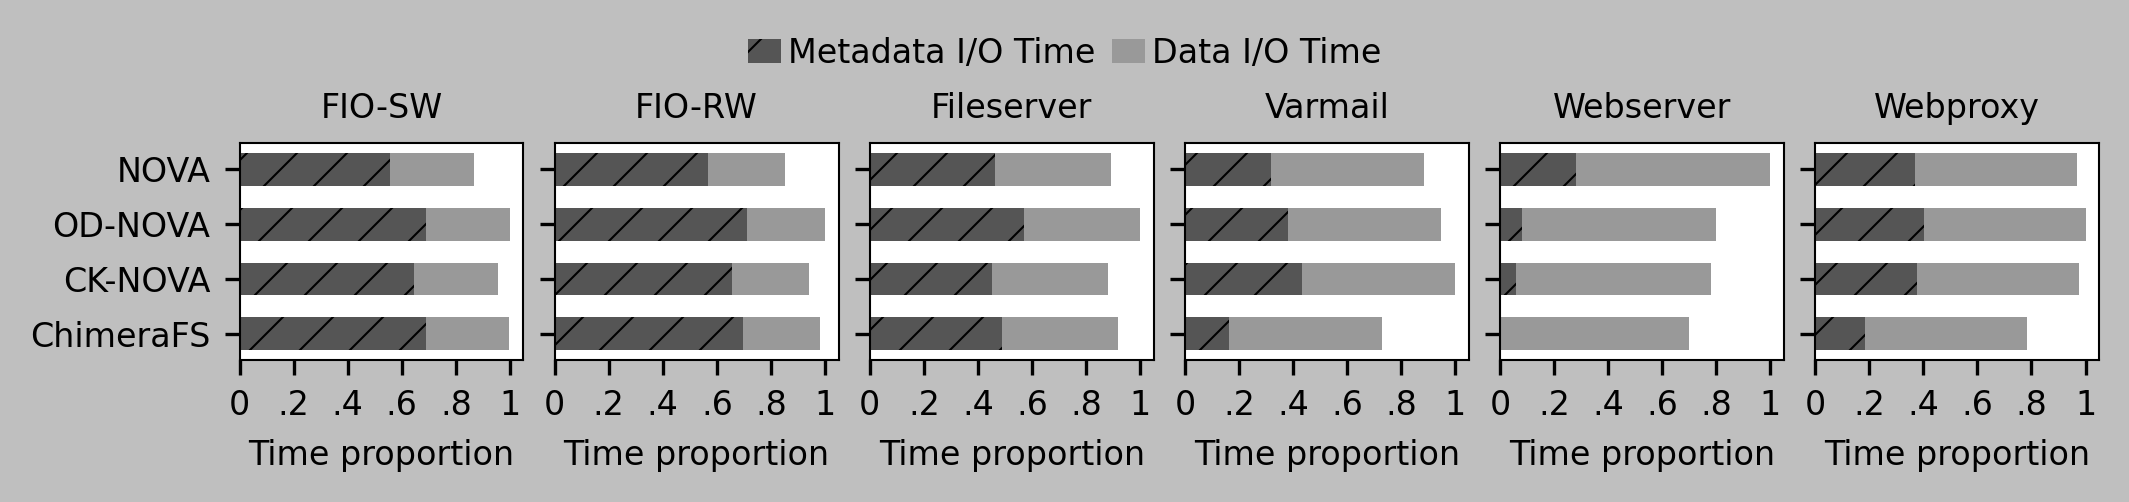

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54

plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42


# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(DOUBLE_COL_WIDTH), cm_to_inch(3.5)))
bar_width = 0.25
true_width = 0.15
inner_width = 0.1
num_job = 1

# grayscale colors
colors = ["#555555", "#999999", "#BBBBBB", "#DDDDDD", "#FFFFFF"]
patterns = ['//', '', '\\\\', "OOO", "///", "\\\\\\", "xxx"]
titles = ["(a) NOVA I/O Time and I/O Size Breakdown", "(b) PMFS I/O Time and I/O Size Breakdown"]
scales = [4, 1]
cmap="tab20"
# 文件路径和文件系统标记
files = [
    "./performance-comparison-table-nova",
    "./performance-comparison-table-nvodin",
    "./performance-comparison-table-cknova",
    "./performance-comparison-table-parfs",
]
fss = ["nova", "nvodin", "cknova", "parfs"]
combine_file = "./performance-comparison-table-combine"

all_data = []
for file, fs in zip(files, fss):
    df = pd.read_csv(file, sep=r"\s+", engine='python')
    df.insert(0, "fs", fs)
    all_data.append(df)

merged_df = pd.concat(all_data, ignore_index=True)

ref_df = merged_df[merged_df["fs"] == "nova"].set_index("workloads")

def compute_meta_data(row):
    if row['fs'] == 'nova':
        return row  # 已有完整数据

    workload = row['workloads']
    total_time = row['total_time(ns)']
    ref_total = ref_df.loc[workload, 'total_time(ns)']
    ref_meta = ref_df.loc[workload, 'meta(ns)']

    diff = ref_total - total_time
    meta = ref_meta - diff
    data = total_time - meta

    row['meta(ns)'] = meta
    row['data(ns)'] = data
    return row

merged_df = merged_df.apply(compute_meta_data, axis=1)
merged_df.to_csv(combine_file, index=False)

files = [combine_file]

# files = ["./avg-test-result-single-in-paper", "../FIG_CP_Prefetch/performance-comparison-table"]
# files = ["./performance-comparison-table-KILLER"] 
        #  "./performance-comparison-table-filebench-PMFS", "performance-comparison-table-fio-PMFS"]
workloads = ["write", "randwrite", "fileserver.f", "varmail.f", "webserver.f", "webproxy.f"]
# workloads = ["write", "randwrite"]
workloads_remap = ["FIO-SW", "FIO-RW", "Fileserver", "Varmail", "Webserver", "Webproxy"]
# workloads_remap = ["SW", "RW"]
# workloads = ["write", "webproxy.f"]
# workloads_remap = ["SW", "WPX"]

# workloads.reverse()
# workloads_remap.reverse()

# breakdown_times = ["data_read_time(ns)", "data_write_time(ns)", "update_entry_time(ns)", "update_inode_time(ns)", "journal_time(ns)", "update_page_tail_time(ns)"]
breakdown_times = ["meta(ns)", "data(ns)"]
# breakdown_IO = [ "data_read(bytes)", "data_write(bytes)", "meta_read(bytes)", "meta_write(bytes)", "media_read(byte)", "media_write(byte)"]
bars = []
global_color_idx = 0
color_map = {}
for fid, file in enumerate(files):
    # subfig = plt.subplot(1, 2, fid + 1)
    with open(file, "r") as f:
        df = pd.read_csv(f, sep=",", engine='python')
    sort_dict = {
        "parfs" : 0, 
        "nvodin": 2,
        "nova": 3,
        "cknova": 1,
    }
    # sort_dict = {
    #     "parfs" : 1, 
    #     "nvodin": 3,
    #     "nova": 4,
    #     "cknova": 2,
    #     "chimerafs": 0,
    # }
    print(df.columns.tolist())
    print(df)
    sort_df = pd.DataFrame(df['fs'].map(sort_dict))
    df = df.iloc[sort_df.sort_values(by = ["fs"]).index]
    print(df)
    fss = df['fs'].drop_duplicates().reset_index().drop(columns=['index'])['fs']
    
    # fss = df['fs'].drop_duplicates().reset_index().drop(columns=['index'])['fs']
    # breakdown_times = ["data_write_time(ns)", "data_read_time(ns)", "update_package_time(ns)", "update_bm_time(ns)"]
    breakdown_times = ["meta(ns)", "data(ns)"]
    # df.columns[14:]
    # breakdown_times = breakdown_times.insert(0, "data_read_time(ns)")
    # breakdown_times = breakdown_times.insert(1, "data_write_time(ns)")
    print(breakdown_times)
    x = list(range(1, len(workloads) + 1))
    
    # ax2 = subfig.twinx()
    pivots = []
    
    workload_map = {
        "write": [],
        "randwrite": [],
        "fileserver.f": [],
        "varmail.f": [],
        "webserver.f": [],
        "webproxy.f": []
    }

    for fs_idx, fs in enumerate(fss):
        for workload_id, workload in enumerate(workloads):
            total_time = 0
            for idx, time in enumerate(breakdown_times):
                width = df[(df['workloads'] == workload) & (df['fs'] == fs)][time].iloc[0]
                total_time += width
            workload_map[workload].append(total_time)
    
    for workload_id, workload in enumerate(workloads):
        pivots = []
        for fs_idx, fs in enumerate(fss):
            subfig = plt.subplot(1, 6, workload_id + 1) 
            # global_color_idx = 0
            global_color_idx = fid * len(breakdown_times) 
            left = 0
            # for pivot in x:
            #     point = pivot - len(fss) * bar_width / 2 + bar_width / 2 + idx * bar_width
            #     points.append(point)
            # - tot / 2 + bar_width / 2 + idx * bar_width
            
            pivot = x[workload_id] - len(fss) * bar_width / 2 + bar_width / 2 + fs_idx * bar_width 
            pivots.append(pivot)
            # + bar_width / 2
            inner_left = 0
            inner_left_range = []
            start = False
            for idx, time in enumerate(breakdown_times):
                width = df[(df['workloads'] == workload) & (df['fs'] == fs)][time].iloc[0] / max(workload_map[workload])
                
                orig_global_color_idx = global_color_idx
                if fid == 1 and idx in [0, 1, 3, 4]:
                    global_color_idx = color_map[time]
                
                bar, = subfig.barh(y=pivot, width=width, color=colors[global_color_idx], left=left, hatch=patterns[idx],linewidth=0.5, label=time, height=true_width)
                left = left + width 
                
                global_color_idx = orig_global_color_idx

                if fid == 0:
                    color_map[time] = global_color_idx
                    global_color_idx += 1
                    if workload_id == 0:
                        bars.append(bar)
                else:
                    if idx not in [0, 1, 3, 4]:
                        global_color_idx += 1
                    if workload_id == 0:
                        if idx not in [0, 1, 3, 4]:
                            bars.append(bar)

        subfig.tick_params(bottom=False, top=False, left=False, right=False)

        # ax2.set_yticks(pivots)
        if workload_id == 0:
            _fss = fss.map({
                "parfs": "ChimeraFS",
                "nova": "NOVA",
                "nvodin": "OD-NOVA",
                "cknova": "CK-NOVA",
            })
            # _fss = fss.map({
            #     "parfs": "Ideal-FS",
            #     "nova": "NOVA",
            #     "nvodin": "OD-NOVA",
            #     "chimerafs": "ChimeraFS",
            #     "cknova": "CK-NOVA",
            # })
            yticklabels = list(_fss)
            subfig.set_yticks(pivots)
            subfig.set_yticklabels(yticklabels, fontsize=8)
        else:
            subfig.set_yticks(pivots)
            subfig.set_yticklabels([], fontsize=8)
        
        subfig.set_title(f"{workloads_remap[workload_id]}", fontsize=8)
        subfig.set_xlim([0, 1.05])
        subfig.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        subfig.set_xticklabels(["0", ".2", ".4", ".6", ".8", "1"], fontsize=8)
        subfig.set_xlabel("Time proportion", fontsize=8)
        
        ax = fig.gca()
        lw = 0.5
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(lw)
        subfig.tick_params(bottom=True, top=False, left=True, right=False, which='major')
    # subfig.set_ylabel("Normalized Write Time per Op", fontsize=8)
    # if fid == 0:
    #     subfig.set_ylim([0, 1])
    #     subfig.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    #     subfig.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=8)
    #     # subfig.set_yticks([0, 0.125, 0.250, 0.375, 0.500, 0.625, 0.750, 0.875, 1.000])
    #     # subfig.set_yticklabels([0, 0.125, 0.250, 0.375, 0.500, 0.625, 0.750,0.875, 1.000], fontsize=8)
    #     # subfig.set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40])
    #     # subfig.set_xticklabels([0, 5, 10, 15, 20, 25, 30, 35, 40], fontsize=8)
    #     pass
    # else:
    #     subfig.set_yticks([0, 11, 22, 33, 44])
    #     subfig.set_yticklabels([0, 11, 22, 33, 44], fontsize=8)
    # ax2.set_ylim(subfig.get_ylim())
    # subfig.set_ylim([1, 3])
    # subfig.set_xticks(x, minor=False)
    # if fid == 0:
    #     subfig.set_xticklabels(workloads_remap, fontsize=8, minor=False)
    # else:
    #     subfig.set_xticklabels([], fontsize=8)

    
    # yticklabels = yticklabels * 6
    # pivots.sort()
    # pivots = [ round(pivot, 1) for pivot in pivots]
    # pivots = [ pivot - 0.001 if pivot in x else pivot for pivot in pivots]
    # print(pivots)
    # subfig.set_xticks(pivots, minor=True)
    # subfig.set_xticklabels(yticklabels, minor=True, fontsize=8, rotation=45, ha="right", rotation_mode="anchor", va="center")
    # subfig.get_xaxis().set_tick_params(which='major', pad=22)
    # print(pivots)
    # subfig.set_yticks(pivots, minor=True)
    # if workload_id == 0:
    #      subfig.set_yticklabels(yticklabels, minor=True, fontsize=8)
    # ax2.set_yticklabels(['Huge+P', 'Huge+P', 'Huge', 'Huge', 'Naive', 'Naive'], fontsize=7)
        
    # subfig.tick_params(bottom=False, top=False, left=False, right=False, which='minor')
    # subfig.title.set_text(titles[fid], fontsize=8)
print(len(bars))
# legends = ["T-D-Rd", "T-D-Wr", "T-M-E", "T-M-I", "T-M-Jnl", "T-M-T", "T-M-Idx", "T-M-DE", "IO-D", "IO-M" ]
# legends = ["D-Write Time", "D-Read Time", "Pkg Time", "CP Time" ]
legends = ["Metadata I/O Time", "Data I/O Time"]
fig.legend(labels=legends, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.15), frameon=False, columnspacing=0.5, handletextpad=0.2, handlelength=1, borderpad=0.2, labelspacing=0.2, fontsize=8)
plt.tight_layout(pad=0.4)
plt.savefig("./FIG-PerfBreakDown.pdf", bbox_inches='tight', pad_inches=0)